In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import math
import ast
from scipy.signal import find_peaks
import pywt
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print("PyTorch version:", torch.__version__)
    print("CUDA version:", torch.version.cuda)
    print("Number of available GPUs:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

CUDA is available.
PyTorch version: 2.1.0+cu121
CUDA version: 12.1
Number of available GPUs: 1
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('data/MoNA/in-silico.csv') 
print(df.shape)

/tmp/ipykernel_1054/2621324627.py:1: DtypeWarning: Columns (6,7,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/MoNA/in-silico.csv')


(1844352, 17)


In [5]:
# Prepare the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['molecular_formula'])

In [6]:
def direct_tokenization(binned_spectrum, window_size=16):
    # Pad the spectrum if necessary
    if len(binned_spectrum) % window_size != 0:
        pad_length = window_size - (len(binned_spectrum) % window_size)
        binned_spectrum = np.pad(binned_spectrum, (0, pad_length), mode='constant')
    
    # Reshape into 2D
    return binned_spectrum.reshape(-1, window_size)

def fourier_tokenization_2d(binned_spectrum, window_size=16):
    fft = np.fft.fft(binned_spectrum)
    magnitude_spectrum = np.abs(fft[:len(fft)//2])
    
    # Pad if necessary
    if len(magnitude_spectrum) % window_size != 0:
        pad_length = window_size - (len(magnitude_spectrum) % window_size)
        magnitude_spectrum = np.pad(magnitude_spectrum, (0, pad_length), mode='constant')
    
    # Reshape into 2D
    return magnitude_spectrum.reshape(-1, window_size)

def wavelet_tokenization_2d(binned_spectrum, window_size=16, wavelet='db1'):
    coeffs = pywt.wavedec(binned_spectrum, wavelet)
    flat_coeffs = np.concatenate(coeffs)
    
    # Pad if necessary
    if len(flat_coeffs) % window_size != 0:
        pad_length = window_size - (len(flat_coeffs) % window_size)
        flat_coeffs = np.pad(flat_coeffs, (0, pad_length), mode='constant')
    
    # Reshape into 2D
    return flat_coeffs.reshape(-1, window_size)

def peak_tokenization(spectrum_string, top_n=50, pad_to=50):
    spectrum = ast.literal_eval(spectrum_string)
    spectrum.sort(key=lambda x: x[1], reverse=True)
    top_peaks = spectrum[:top_n]
    flattened = [val for peak in top_peaks for val in peak]
    
    # Pad if necessary
    if len(flattened) < pad_to * 2:
        flattened.extend([0] * (pad_to * 2 - len(flattened)))
    
    return np.array(flattened).reshape(-1, 2)

In [7]:
'''
def fourier_tokenization_2d(binned_spectrum, window_size=16):
    # Perform FFT
    fft = np.fft.fft(binned_spectrum)
    magnitude_spectrum = np.abs(fft[:len(fft)//2])
    
    # Pad the spectrum if necessary
    if len(magnitude_spectrum) % (window_size * window_size) != 0:
        pad_length = window_size * window_size * (len(magnitude_spectrum) // (window_size * window_size) + 1) - len(magnitude_spectrum)
        magnitude_spectrum = np.pad(magnitude_spectrum, (0, pad_length), mode='constant')
    
    # Reshape into 2D
    num_windows = len(magnitude_spectrum) // (window_size * window_size)
    reshaped = magnitude_spectrum.reshape(num_windows, window_size, window_size)
    
    # Flatten each window
    return reshaped.reshape(num_windows, -1).tolist()

def wavelet_tokenization_2d(binned_spectrum, window_size=16, wavelet='db1'):
    # Perform wavelet transform
    coeffs = pywt.wavedec(binned_spectrum, wavelet)
    
    # Concatenate all levels
    flat_coeffs = np.concatenate(coeffs)
    
    # Pad if necessary
    if len(flat_coeffs) % (window_size * window_size) != 0:
        pad_length = window_size * window_size * (len(flat_coeffs) // (window_size * window_size) + 1) - len(flat_coeffs)
        flat_coeffs = np.pad(flat_coeffs, (0, pad_length), mode='constant')
    
    # Reshape into 2D
    num_windows = len(flat_coeffs) // (window_size * window_size)
    reshaped = flat_coeffs.reshape(num_windows, window_size, window_size)
    
    # Flatten each window
    return reshaped.reshape(num_windows, -1).tolist()
'''

"\ndef fourier_tokenization_2d(binned_spectrum, window_size=16):\n    # Perform FFT\n    fft = np.fft.fft(binned_spectrum)\n    magnitude_spectrum = np.abs(fft[:len(fft)//2])\n    \n    # Pad the spectrum if necessary\n    if len(magnitude_spectrum) % (window_size * window_size) != 0:\n        pad_length = window_size * window_size * (len(magnitude_spectrum) // (window_size * window_size) + 1) - len(magnitude_spectrum)\n        magnitude_spectrum = np.pad(magnitude_spectrum, (0, pad_length), mode='constant')\n    \n    # Reshape into 2D\n    num_windows = len(magnitude_spectrum) // (window_size * window_size)\n    reshaped = magnitude_spectrum.reshape(num_windows, window_size, window_size)\n    \n    # Flatten each window\n    return reshaped.reshape(num_windows, -1).tolist()\n\ndef wavelet_tokenization_2d(binned_spectrum, window_size=16, wavelet='db1'):\n    # Perform wavelet transform\n    coeffs = pywt.wavedec(binned_spectrum, wavelet)\n    \n    # Concatenate all levels\n    flat_c

In [8]:
def calculate_max_mz(df, spectrum_column='spectrum'):
    def get_max_mz(spectrum_string):
        spectrum = ast.literal_eval(spectrum_string)
        return max(peak[0] for peak in spectrum)

    max_mz_series = df[spectrum_column].apply(get_max_mz)
    return int(np.ceil(max_mz_series.max()))

def bin_spectrum(spectrum_string, max_mz):
    spectrum = ast.literal_eval(spectrum_string)
    binned = np.zeros(max_mz + 1)  # +1 to include the max_mz value
    
    for mz, intensity in spectrum:
        mz_int = int(np.round(mz))
        if mz_int <= max_mz:
            binned[mz_int] += intensity
    
    return binned

def variable_density_bin_spectrum(spectrum_string, max_mz):
    spectrum = ast.literal_eval(spectrum_string)
    binned = np.zeros(max_mz+1)
    for mz, intensity in spectrum:
        continue
    pass

def tokenize_spectrum(spectrum, method, max_mz, window_size=16):
    if isinstance(spectrum, str):
        binned_spectrum = bin_spectrum(spectrum, max_mz)
    else:
        binned_spectrum = spectrum

    if method == 'direct':
        return direct_tokenization(binned_spectrum, window_size)
    elif method == 'peak':
        return peak_tokenization(spectrum)
    elif method == 'fourier2':
        return fourier_tokenization_2d(binned_spectrum, window_size)
    elif method == 'wavelet2':
        return wavelet_tokenization_2d(binned_spectrum, window_size)
    else:
        raise ValueError(f"Unknown tokenization method: {method}")


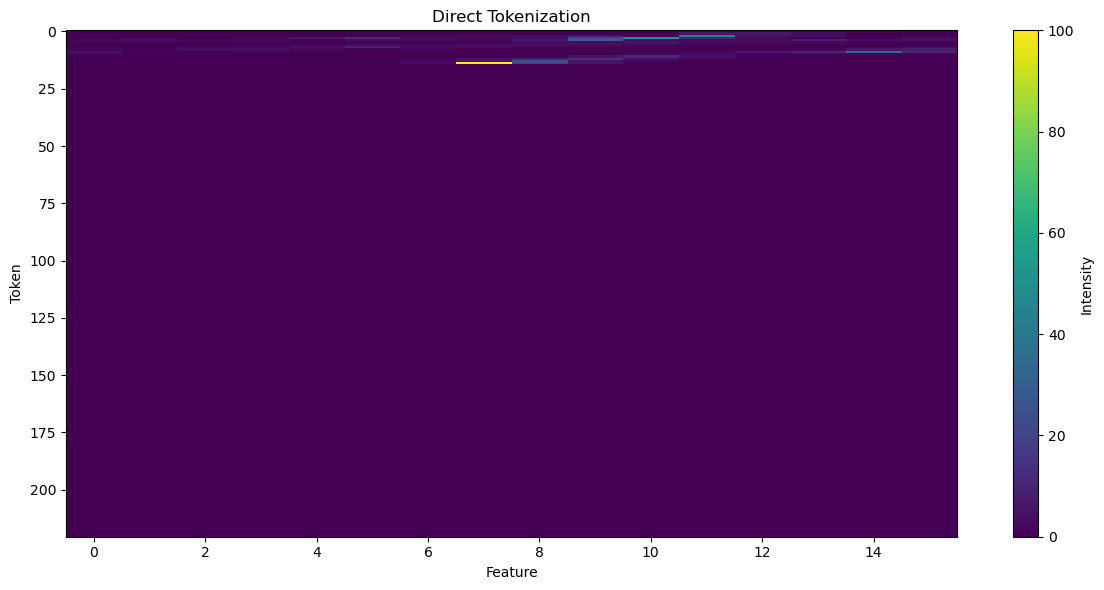

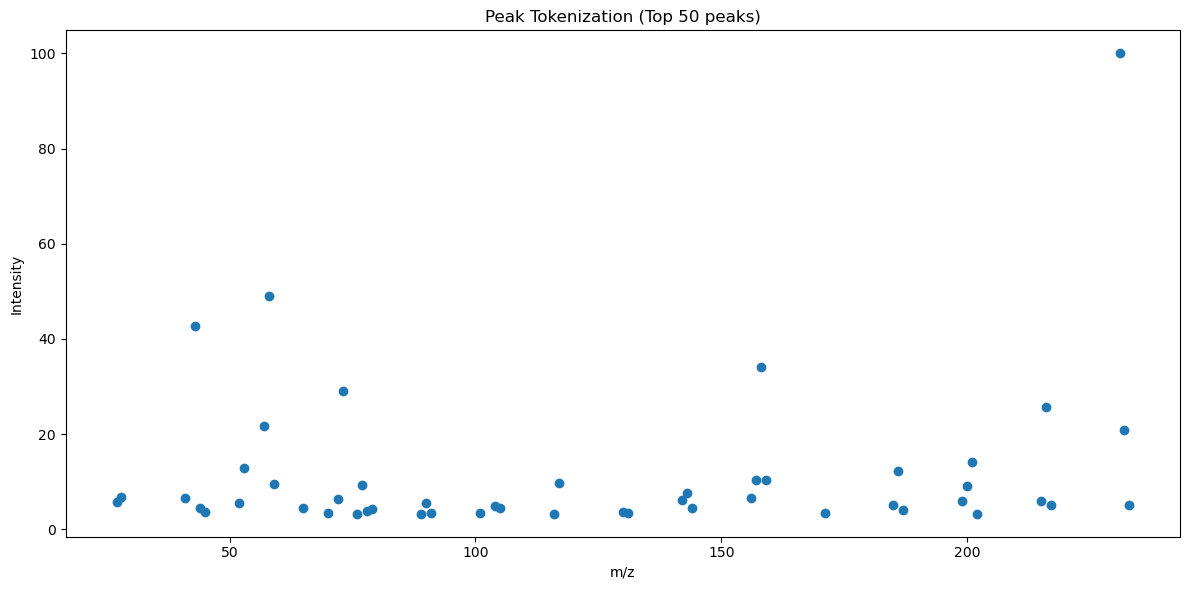

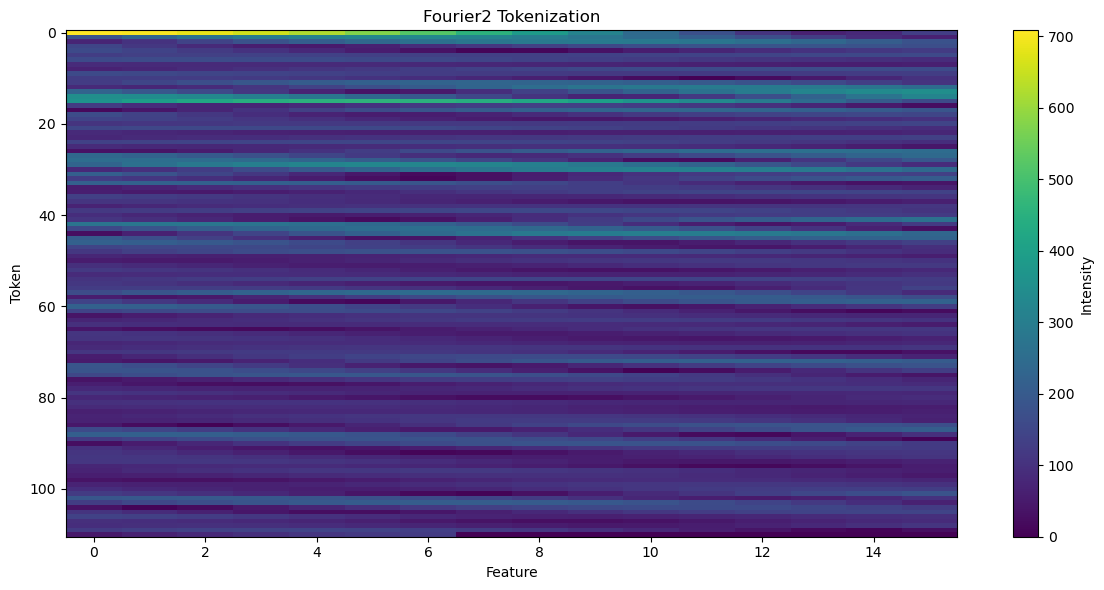

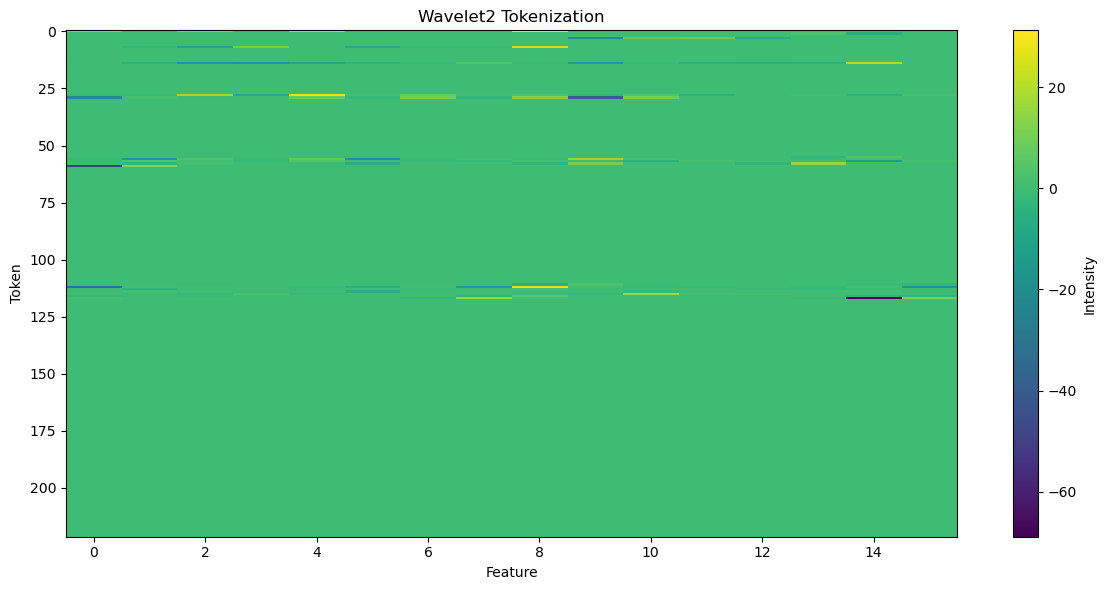

In [9]:
def visualize_tokenization(spectrum, method, max_mz, window_size=16):
    tokenized = tokenize_spectrum(spectrum, method, max_mz, window_size)
    
    plt.figure(figsize=(12, 6))
    
    if method == 'peak':
        plt.scatter(tokenized[:, 0], tokenized[:, 1])
        plt.xlabel('m/z')
        plt.ylabel('Intensity')
        plt.title(f'Peak Tokenization (Top {tokenized.shape[0]} peaks)')
    else:
        plt.imshow(tokenized, aspect='auto', interpolation='nearest')
        plt.colorbar(label='Intensity')
        plt.xlabel('Feature')
        plt.ylabel('Token')
        plt.title(f'{method.capitalize()} Tokenization')
    
    plt.tight_layout()
    plt.show()

# Function to get a sample spectrum
def get_sample_spectrum(df):
    return df['spectrum'].iloc[0]

# Visualize each method
max_mz = calculate_max_mz(df)
sample_spectrum = get_sample_spectrum(df)
for method in ['direct', 'peak', 'fourier2', 'wavelet2']:
    visualize_tokenization(sample_spectrum, method, max_mz)

In [10]:
for method in ['direct', 'peak', 'fourier2', 'wavelet2']:
    print(tokenize_spectrum(sample_spectrum, method, max_mz, 16).shape)

(221, 16)
(50, 2)
(111, 16)
(222, 16)


In [11]:
class SpectralDataset(Dataset):
    def __init__(self, df, labels, tokenization_method, max_mz):
        self.spectra = df['spectrum']
        self.labels = labels
        self.tokenization_method = tokenization_method
        self.max_mz = max_mz

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        spectrum = self.spectra.iloc[idx]
        label = self.labels[idx]
        tokenized = tokenize_spectrum(spectrum, self.tokenization_method, self.max_mz)
        return torch.tensor(tokenized, dtype=torch.float32).unsqueeze(0), label  # Add an extra dimension

In [12]:
# Calculate max_mz
max_mz = calculate_max_mz(df)
print(f"Maximum m/z value across all spectra: {max_mz}")    

Maximum m/z value across all spectra: 3533


In [13]:
# Split the data
X_train = df
X_test = df
y_train = y
y_test = y

In [14]:
def load_tokenized_data(method, batch_size=32):
    train_dataset = SpectralDataset(X_train, y_train, method, max_mz)
    test_dataset = SpectralDataset(X_test, y_test, method, max_mz)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [15]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

class MS_VIT(nn.Module):
    def __init__(self, num_classes, embed_depth=16, d_model=256, nhead=8, num_layers=6, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        # Initial embedding layer
        self.embedding = nn.Linear(embed_depth, d_model)
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        # Final classification layer
        self.fc = nn.Linear(d_model, num_classes)
        
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src shape: (batch_size, seq_length, 16)
        # Embed the input
        src = self.embedding(src) * math.sqrt(self.d_model)
        # Add positional encoding
        src = self.pos_encoder(src.transpose(0, 1))
        # Pass through transformer encoder
        output = self.transformer_encoder(src)
        # Global average pooling
        output = output.mean(dim=0)
        # Classification
        output = self.fc(output)
        
        return output


In [16]:
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=50):
    device = next(model.parameters()).device
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        # progress bar
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
    
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Reshape input: (batch_size, 1, seq_length, 16) -> (batch_size, seq_length, 16)
            x_batch = x_batch.squeeze(1)
            
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            # Update progress bar description with current loss
            train_pbar.update(1)
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        '''
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0

        # Create progress bar for evaluation
        test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]', leave=False)
        
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                x_batch = x_batch.squeeze(1)
                outputs = model(x_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

                # Update progress bar description with current accuracy
                accuracy = correct / total
                test_pbar.update(1)
                test_pbar.set_postfix({'accuracy': f'{accuracy:.4f}'})
        
        accuracy = correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}')
        '''
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')
    return model

In [17]:
results = {}
for method in ['direct', 'peak', 'fourier2', 'wavelet2']:
    print(f"\nTraining with {method} tokenization:")
    
    train_loader, test_loader = load_tokenized_data(method)
    
    # Get a sample batch to determine input dimensions
    sample_batch, _ = next(iter(train_loader))
    print('Sample shape:', sample_batch.shape)
    #print('Sample first element:', sample_batch[0])
    
    num_classes = len(label_encoder.classes_)
    embed_depth = sample_batch.shape[3]
    
    model = MS_VIT(num_classes, embed_depth=embed_depth,
                   d_model=64, nhead=2, num_layers=2,
                   ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    
    model = train_model(model, train_loader, test_loader, optimizer, criterion,
                        num_epochs=10)
    
    # Final evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            x_batch = x_batch.squeeze(1)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    accuracy = correct / total
    results[method] = accuracy
    print(f"Final accuracy with {method} tokenization: {accuracy:.4f}")


Training with direct tokenization:
Sample shape: torch.Size([32, 1, 221, 16])


/home/kyle/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 1/10, Loss: 6.0775


Epoch 2/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 2/10, Loss: 3.0525


Epoch 3/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.7949


Epoch 4/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.2461


Epoch 5/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.9903


Epoch 6/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.8487


Epoch 7/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.7627


Epoch 8/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7030


Epoch 9/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.6613


Epoch 10/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.6279
Final accuracy with direct tokenization: 0.8621

Training with peak tokenization:
Sample shape: torch.Size([32, 1, 50, 2])


/home/kyle/anaconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 1/10, Loss: 6.4885


Epoch 2/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 2/10, Loss: 4.6703


Epoch 3/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 3/10, Loss: 4.1236


Epoch 4/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 4/10, Loss: 3.9147


Epoch 5/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 5/10, Loss: 4.0260


Epoch 6/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 6/10, Loss: 3.6207


Epoch 7/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 7/10, Loss: 3.5240


Epoch 8/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 8/10, Loss: 3.4600


Epoch 9/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 9/10, Loss: 3.6222


Epoch 10/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 10/10, Loss: 3.4279
Final accuracy with peak tokenization: 0.0784

Training with fourier2 tokenization:
Sample shape: torch.Size([32, 1, 111, 16])


Epoch 1/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 1/10, Loss: 6.1265


Epoch 2/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 2/10, Loss: 4.5585


Epoch 3/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 3/10, Loss: 4.1384


Epoch 4/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 4/10, Loss: 3.8875


Epoch 5/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 5/10, Loss: 3.8428


Epoch 6/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 6/10, Loss: 3.6039


Epoch 7/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 7/10, Loss: 3.4927


Epoch 8/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 8/10, Loss: 3.3996


Epoch 9/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 9/10, Loss: 3.3379


Epoch 10/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 10/10, Loss: 3.2802
Final accuracy with fourier2 tokenization: 0.2630

Training with wavelet2 tokenization:
Sample shape: torch.Size([32, 1, 222, 16])


Epoch 1/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 1/10, Loss: 6.3212


Epoch 2/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 2/10, Loss: 3.0032


Epoch 3/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.7439


Epoch 4/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.2678


Epoch 5/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.0284


Epoch 6/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.8975


Epoch 7/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.8219


Epoch 8/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.7781


Epoch 9/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.7480


Epoch 10/10 [Train]:   0%|          | 0/57636 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.7246
Final accuracy with wavelet2 tokenization: 0.8366


In [18]:
# Compare results
for method, accuracy in results.items():
    print(f"{method} tokenization accuracy: {accuracy:.4f}")

direct tokenization accuracy: 0.8621
peak tokenization accuracy: 0.0784
fourier2 tokenization accuracy: 0.2630
wavelet2 tokenization accuracy: 0.8366
